In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from collections import deque

In [7]:
df = pd.read_csv('data.csv',index_col='Date')

# Make some targets for the model to predict with 
- target is the variable 
- seq_len is how many days we will use to predict 
- future_pred is the amount of days we will try to predict into the future. 

    - The classify clause allows you to make a dummy column indicating a buy or a sell signal 
    - when the future price is greater than the current price, this is a buy signal. 
    - when the future price is less than the current price, this is a sell or neutral signal. 

In [8]:
stock = "aapl"
seq_len = 15
future_pred = 5

def classify(current, future):
    if float(future) >float(current):
        return 1
    else:
        return 0

In [17]:
# Check to make sure that the future price is shifted 3 time units upward
#df[[f"Close_{stock}",'future','target']].head(10)
def shift_target(df, stock, seq_len, future_pred):
    df = df[[f"Close_{stock}", f"Volume_{stock}"]].copy()
    df['future'] = df[f"Close_{stock}"].shift(-future_pred) # Shifting the Price Variable, (From the most recent) 
    df['target'] = list(map(classify,df[f"Close_{stock}"],df['future'])) # Classifying Current Price with Future Price (Lagged Vs. Current)
    return df

data_df = shift_target(df, 'aapl', seq_len, future_pred)
data_df.head()

,Close_aapl,Volume_aapl,future,target
Date,,,,
2016-12-05,27.277500,137298000.0,28.325001,1
2016-12-06,27.487499,104782000.0,28.797501,1
2016-12-07,27.757500,119994800.0,28.797501,1
2016-12-08,28.030001,108273200.0,28.955000,1
2016-12-09,28.487499,137610400.0,28.992500,1


# Need to seperate out of sample data.
- good practice for time series
- without doing this the model will overfit, causing the loss to skyrocket. 
- seperating the last 5% of the data allows us to forward test on the last 5 percent. 

In [18]:
def split_data(df):
    df = df.copy()
    time = sorted(df.index.values) # Sorting the Date values. 
    last5 = time[-int(0.05*len(time))] # Last 5% of the data Used for Validation
    val_df = df[df.index>=last5] # Validation Data
    df = df[df.index<=last5] # Training Data
    return df, val_df

train_df, val_df = split_data(data_df)

print(f'validation: {len(val_df)}')
print(f'df: {len(train_df)}')

validation: 57
df: 1084


# Normalizing data. 
- normalize the data
- create the sequences we want to use to predict on
- balance the dataset 

In [19]:
def prep_df(df):
    df = df.drop('future',axis=1)
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change() # gets the percent change 
            df.dropna(inplace=True)
            df[col] = preprocessing.scale(df[col].values) # Scaling the data. 
    df.dropna(inplace=True)

    seq_data = []
    prev_days = deque(maxlen = seq_len) # appends all the data to the empty list, as it gets new items it deletes the old items 

    for i in df.values:
        prev_days.append([n for n in i[:-1]]) # each of the columns up to the last column (target)
        if len(prev_days) == seq_len:
            seq_data.append([np.array(prev_days), i[-1]])
    np.random.shuffle(seq_data)

    # balance the data 
    buys = []
    sells = []
    for seq, target in seq_data:
        if target== 0:
            sells.append([seq,target])
        elif target ==1:
            buys.append([seq, target])

    np.random.shuffle(buys)
    np.random.shuffle(sells)

    lower = min(len(buys), len(sells))
    buys = buys[:lower]
    sells = sells[:lower]

    seq_data = buys+sells
    np.random.shuffle(seq_data)

    X = []
    y = []
    
    for seq, target in seq_data:
        X.append(seq)
        y.append(target)
    
    return(np.array(X),np.array(y))

In [20]:
train_x, train_y = prep_df(train_df)
val_x, val_y = prep_df(val_df)

In [26]:
print('Train Data Shape: ',train_x.shape,'Validation Data Shape: ', val_x.dtype)

Train Data Shape:  (802, 15, 2) Validation Data Shape:  float64


In [27]:
print(f'train data: {len(train_x)} validation: {len(val_x)}')
#print(f'Sells: {train_y.count(0)}', f'Buys: {train_y.count(1)}')
#print(f'ValidationSells: {val_y.count(0)}', f'ValidationBuys: {val_y.count(1)}')


train data: 802 validation: 34


# Creating the model 

In [28]:
import datetime as dt 
import tensorflow as tf 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,LSTM,BatchNormalization
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

Init Plugin
Init Graph Optimizer
Init Kernel


In [29]:
ep = 10 
batch_size = 64
name = f'{stock}-stock-{seq_len}-seq-{future_pred}=pred-{dt.time()}'


In [30]:
model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.1))
model.add(BatchNormalization())

model = Sequential()
model.add(tf.keras.layers.LSTM(128,input_shape=(train_x.shape[1:])))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
model.compile(loss= 'sparse_categorical_crossentropy',optimizer= opt, metrics = ['accuracy'])

# callbacks 
tensorboard = TensorBoard(log_dir=f'logs/{name}')
filepath = "RNN_FINAL-{epoch:02d}-{val_accuracy:.3f}"
checkpoint = ModelCheckpoint('models/{}.h5'.format(filepath, monitor='val_accuracy', save_best_only= True, mode= 'max'))


Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-08-15 15:28:50.705977: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-15 15:28:50.706174: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-08-15 15:28:52.020672: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-15 15:28:52.020689: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-15 15:28:52.020754: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


In [31]:
history = model.fit(
    train_x,train_y, 
    batch_size= batch_size,
    epochs = ep,
    validation_data= (val_x, val_y),
    callbacks=[tensorboard,checkpoint]
    )

2022-08-15 15:28:58.730785: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-15 15:28:58.731461: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/10


2022-08-15 15:28:59.649479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-15 15:29:00.064059: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-15 15:29:04.868384: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


 6/13 [============>.................] - ETA: 0s - loss: 0.7600 - accuracy: 0.5156

2022-08-15 15:29:06.586299: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2022-08-15 15:29:06.586319: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2022-08-15 15:29:06.623882: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-08-15 15:29:06.625546: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2022-08-15 15:29:06.628415: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/aapl-stock-15-seq-5=pred-00:00:00/train/plugins/profile/2022_08_15_15_29_06
2022-08-15 15:29:06.629155: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/aapl-stock-15-seq-5=pred-00:00:00/train/plugins/profile/2022_08_15_15_29_06/Jerald2020.local.trace.json.gz
2022-08-15 15:29:06.631581: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/a

13/13 [==============================] - ETA: 0s - loss: 0.7528 - accuracy: 0.5112

2022-08-15 15:29:08.806612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-15 15:29:08.954376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 10s 214ms/step - loss: 0.7528 - accuracy: 0.5112 - val_loss: 0.6954 - val_accuracy: 0.4412
Epoch 2/10
13/13 [==============================] - 1s 51ms/step - loss: 0.7351 - accuracy: 0.5474 - val_loss: 0.6954 - val_accuracy: 0.3824
Epoch 3/10
13/13 [==============================] - 1s 54ms/step - loss: 0.7056 - accuracy: 0.5424 - val_loss: 0.6962 - val_accuracy: 0.3824
Epoch 4/10
13/13 [==============================] - 1s 41ms/step - loss: 0.6986 - accuracy: 0.5461 - val_loss: 0.6948 - val_accuracy: 0.3529
Epoch 5/10
13/13 [==============================] - 0s 33ms/step - loss: 0.6849 - accuracy: 0.5761 - val_loss: 0.6952 - val_accuracy: 0.3824
Epoch 6/10
13/13 [==============================] - 0s 28ms/step - loss: 0.6948 - accuracy: 0.5648 - val_loss: 0.6950 - val_accuracy: 0.4118
Epoch 7/10
13/13 [==============================] - 0s 30ms/step - loss: 0.6795 - accuracy: 0.5736 - val_loss: 0.6952 - val_accuracy: 0.3824
Epoch 8/10
13/13 [====

<AxesSubplot:>

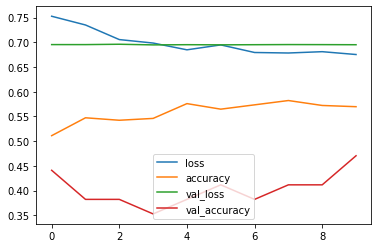

In [32]:
import matplotlib.pyplot as plt 
%matplotlib inline
resdf = pd.DataFrame(history.history)
resdf.plot()

In [33]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = np.argmax(model.predict(val_x), axis=1)
print(classification_report(val_y,predictions))

2022-08-15 15:29:59.006595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-08-15 15:29:59.059722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

         0.0       0.47      0.53      0.50        17
         1.0       0.47      0.41      0.44        17

    accuracy                           0.47        34
   macro avg       0.47      0.47      0.47        34
weighted avg       0.47      0.47      0.47        34



In [34]:
predictions

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1])